# Dataset Challenge

https://physionet.org/content/challenge-2015/1.0.0/

Data are sourced from four hospitals in the USA and Europe.

The full datasetset contains 750 recordings.

An alarm was triggered at the end of these recordings lasting 5 minutes

In [241]:
# Dataset managing tools
import wfdb
import os
from sklearn.utils import class_weight

# Tensorflow
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import optuna

# General
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import scipy as sp

In [242]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

In [243]:
from sklearn.neural_network import MLPClassifier

In [244]:
dataset_path = "../Huawei_challenge/input/alarm-fatigue/dataset/"

In [245]:
patient = "a103l"

record = wfdb.rdrecord(dataset_path + patient)

# DESCRIZIONE

# Contiene i segnali registrati [riga, colonna] = [tempo, canale]
# record.p_signal 

# Contiene il numero dei segnali registrati
# record.n_sig

# Contiene la frequenza di campionamento
# record.fs

# Contiene il nome della registrazione
# record.record_name

# Contiene la tipologia di allarme e se l'allarme è vero o falso [tipo, V/F] es: ['Asystole', 'False alarm']
# record.comments

# Per altre informazioni
# help(record)

In [246]:
# Get a set of patients

unwanted_files = [".ipynb_checkpo", "AL", "MD5", "REC", "SHA1", "SHA256"]

patient_set = set()
for file in os.listdir(dataset_path):
    if not file[:-4] in unwanted_files:
        patient_set.add(file[:-4])

## Explore dataset

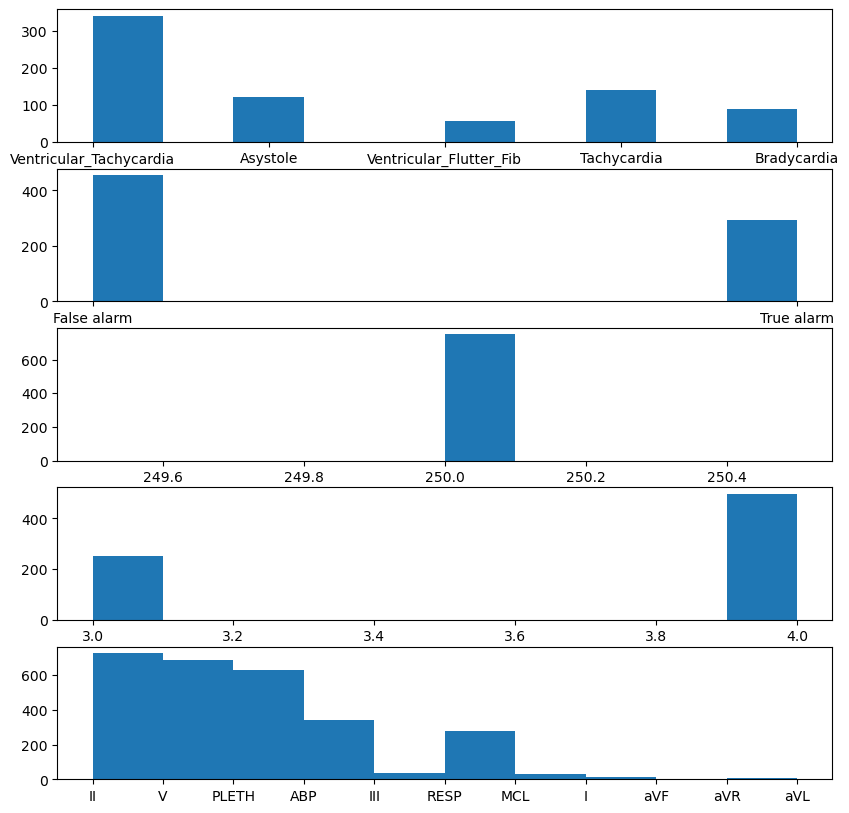

In [247]:
# See which are the labels, the sampling frequency, and the types of alarms

labels_list, fs_list, alert_type_list, n_signal_list, signal_type_list = list(), list(), list(), list(), list()
for patient in patient_set:
    
    # Read the patient record
    record = wfdb.rdrecord(dataset_path + patient)
    
    # Retrieve the information
    fs_list.append(record.fs)
    alert_type_list.append(record.comments[0])
    labels_list.append(record.comments[1])
    n_signal_list.append(record.n_sig)
    for signal_type in record.sig_name:
        signal_type_list.append(signal_type)
    
# Plot 

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10,10))

ax[0].hist(alert_type_list)
ax[1].hist(labels_list)
ax[2].hist(fs_list)
ax[3].hist(n_signal_list)
ax[4].hist(signal_type_list)

plt.show()

del labels_list, fs_list, alert_type_list, n_signal_list, signal_type_list

In [248]:
labels_dict, fs_dict, alert_type_dict, signals_dict, n_signals_dict = dict(), dict(), dict(), dict(), dict()
for patient in patient_set:
    
    # Read the patient record
    record = wfdb.rdrecord(dataset_path + patient)
    
    # Retrieve the information
    fs_dict[patient] = record.fs # Sampling frequency
    alert_type_dict[patient] = record.comments[0] # Alert medical condition type
    labels_dict[patient] = record.comments[1] # True/False alarm
    signals_dict[patient] = record.p_signal # Signals
    n_signals_dict[patient] = record.n_sig # Number of signals

In [249]:
# See the proportions between the type of medical condition alarm and the true/false rate

result = dict()

for patient in patient_set:
    
    alert_type = alert_type_dict[patient]
    label = labels_dict[patient]
    
    # Bool correction
    if label == "True alarm":
        label = True
    elif label == "False alarm":
        label = False
    
    
    if alert_type in result.keys():
        previous = result[alert_type]
        previous.append(label)
        result[alert_type] = previous
        
    else:
        result[alert_type] = [label]
        
# Print True/false and proportions
for alert_type in result.keys():
    
    n_trues = np.count_nonzero(result[alert_type])
    n_falses = len(result[alert_type]) - n_trues
    
    print(alert_type, "\n  - True:", n_trues, "\n  - False:", n_falses)
    print("  - Proportions Falses/Total:", np.around(n_falses/(n_falses+n_trues)*100, 2),"%")

del result

Ventricular_Tachycardia 
  - True: 89 
  - False: 252
  - Proportions Falses/Total: 73.9 %
Asystole 
  - True: 22 
  - False: 100
  - Proportions Falses/Total: 81.97 %
Ventricular_Flutter_Fib 
  - True: 6 
  - False: 52
  - Proportions Falses/Total: 89.66 %
Tachycardia 
  - True: 131 
  - False: 9
  - Proportions Falses/Total: 6.43 %
Bradycardia 
  - True: 46 
  - False: 43
  - Proportions Falses/Total: 48.31 %


In [250]:
del labels_dict, fs_dict, alert_type_dict, signals_dict, n_signals_dict

## Selecting only patients with a given set of the same signals

This is done to simplify the problem and to see if the solution is applicable and easy to develop in real life.

Lead II, Lead V and PLETH are the most common type of signals. Thus I consider only the patients having those signals as my dataset

In [251]:
selected_patient_set = set()

for patient in patient_set:
    
    # Read the patient record
    record = wfdb.rdrecord(dataset_path + patient)
    
    # Retrieving what type of signals we have for the selected patient
    signals_names = record.sig_name
    
    if (("II" in signals_names) and ("V" in signals_names) and ("PLETH" in signals_names)):
        selected_patient_set.add(patient)

## Using only training set (validation set is specified later)

In [252]:
# Encoding medical condition as a vector

first_target_encoder =   {"Bradycardia":             [1,0,0,0,0],
                          "Ventricular_Tachycardia": [0,1,0,0,0], 
                          "Asystole":                [0,0,1,0,0], 
                          "Ventricular_Flutter_Fib": [0,0,0,1,0],
                          "Tachycardia":             [0,0,0,0,1]}

## Setting the number of seconds (from the end) that are considered for the time series

In [253]:
# The model receives the last "time_seconds" seconds of the time series data
# If you want to use all the data set time_seconds to None (approx 5 minutes => maximum time_seconds is 300)
time_seconds = 6

### Train

In [254]:
# Creating the train set

train_alert_type, train_labels, train_signals = dict(), dict(), dict()
for patient in selected_patient_set:
    
    # Read the patient record
    record = wfdb.rdrecord(dataset_path + patient)
    
    # Retrieving what type of signals we have for the selected patient
    signals_names = record.sig_name
    
    # Delete unwanted channels
    array = record.p_signal # Signals
    i = 0
    to_delete = list()
    for signal_name in record.sig_name:
        if not signal_name in ["II", "V", "PLETH"]:
            to_delete.append(i)
        i+=1
    for i in to_delete:
        array = np.delete(array, i, 1)
    
    train_signals[patient] = array
    
    # Retrieve the information
    train_alert_type[patient] = first_target_encoder[record.comments[0]] # Alert medical condition type (first targert)
    
    label = record.comments[1]
    
    # Bool encoder
    if label == "True alarm":
        label = 1
    elif label == "False alarm":
        label = 0
        
    train_labels[patient] = label # True/False alarm (second target)
    

In [255]:
# Train
train_signals = list(train_signals.values())

if time_seconds == None:
    # Computing the minimum length of the signal
    minimum = len(train_signals[0])
    for s in train_signals:
        if len(s) < minimum:
            minimum = len(s)
else:   
    # Cutting the array 60 seconds before alarm instead of using all the 5 minutes at my disposal
    minimum = int(250*time_seconds)

# Cutting for having the same array length in input (as they all are 250Hz sampling frequency) from the end (after the end we have the alarm)
for i, signal in enumerate(train_signals):
    train_signals[i] = np.array(signal[-minimum:, :])

X_train = np.array(train_signals)
y1_train = np.array(list(train_alert_type.values()))
y2_train = np.array(list(train_labels.values()))

del train_signals, train_labels, train_alert_type

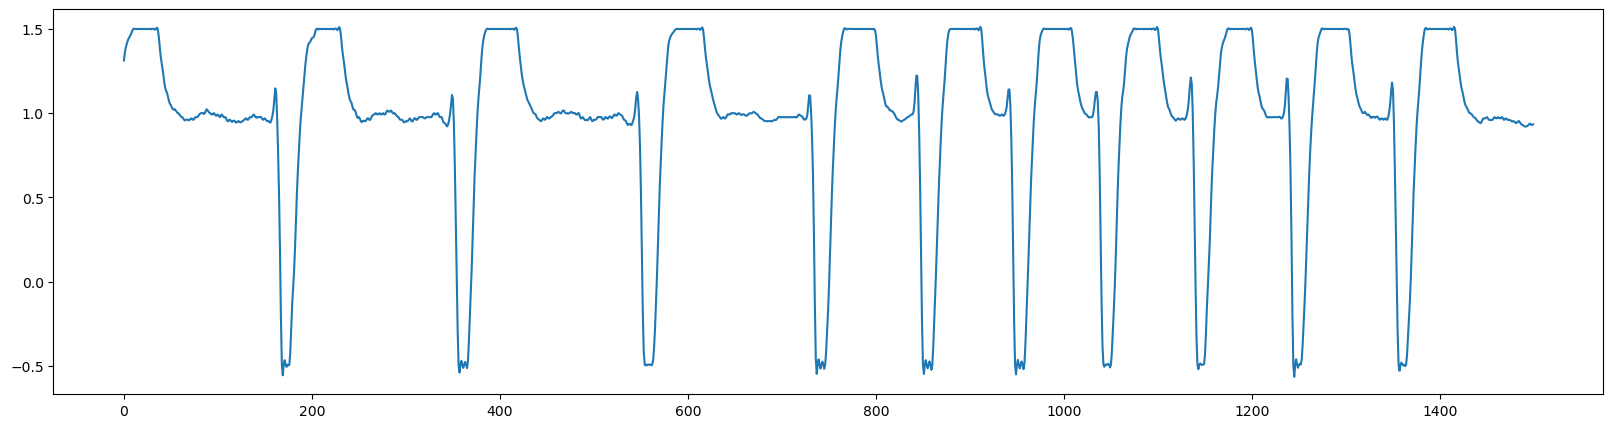

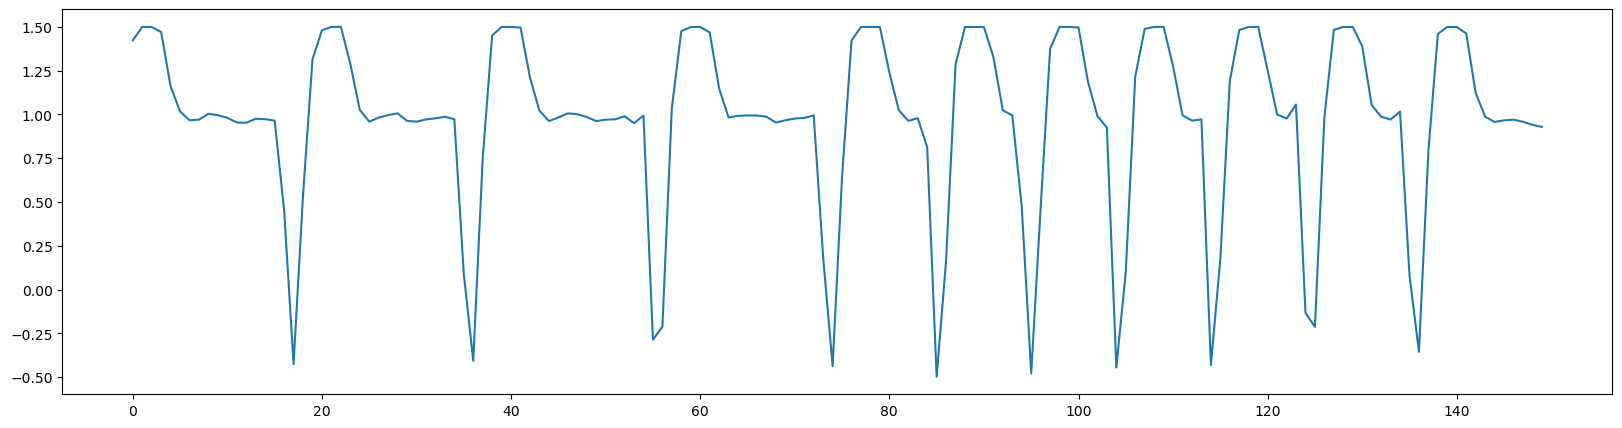

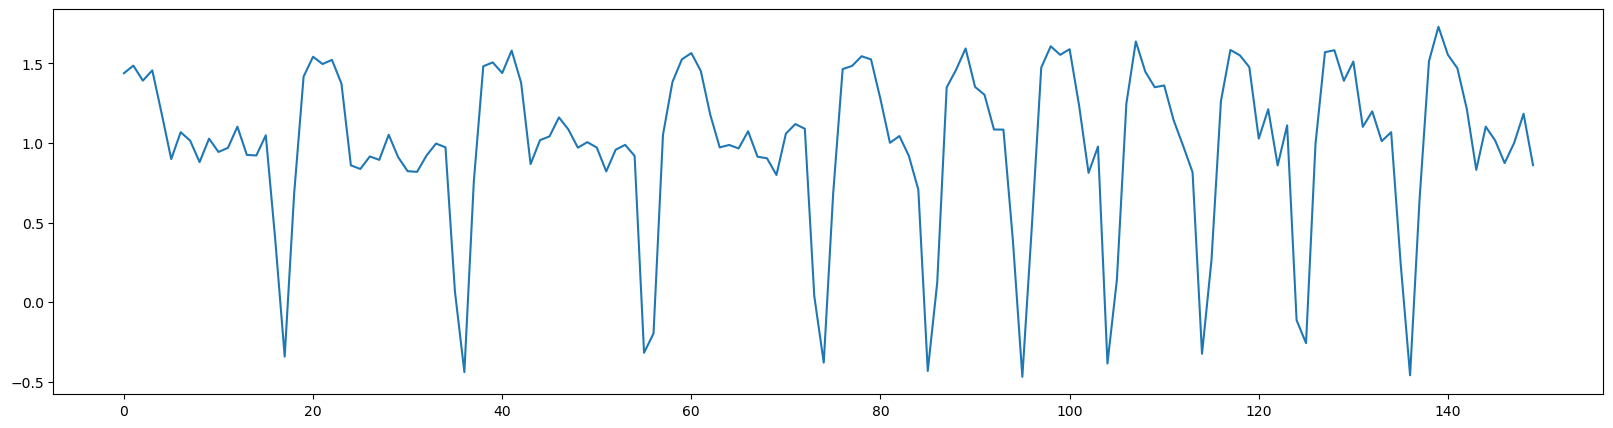

In [256]:
signal = X_train[10].transpose()[1]
decimated_signal = tfkl.AveragePooling1D(pool_size=10, strides=10)(tf.reshape(signal, [1, len(signal), 1]))

plt.figure(figsize=(20,5))
plt.plot(signal)
plt.show()

plt.figure(figsize=(20,5))
plt.plot(np.array(decimated_signal).flatten())
plt.show()

plt.figure(figsize=(20,5))
plt.plot(np.array(decimated_signal).flatten() + np.random.normal(0, 0.1, size=len(np.array(decimated_signal).flatten())))
plt.show()

## Taking care of NaNs in the signals

In [257]:
# the following patients present nan values
np.unique(np.argwhere(np.isnan(X_train) != False).transpose()[0])

array([ 49,  69, 149, 151, 165, 179, 283, 297, 298, 315, 316, 338, 368,
       414, 417, 424, 464, 528], dtype=int64)

In [258]:
# Count how manyn nans we have in the dataset
np.count_nonzero(np.isnan(X_train))

26427

In [259]:
def replace_nans(X_train_n):
    
    #osservazioni (n), sample (j), segnale (i)
    # segnale 0 -........
    # segnale 1 ---..,.-
    # segnale 2 .-.-....-.
    
    for i, signal in enumerate(X_train_n.transpose()):
    
        nan_position = np.argwhere(np.isnan(signal)).transpose()[0]
        #print(nan_position)

        # j contains the argument (position) of where it is nan
        for j in nan_position:
            if (j == 0):
                X_train_n[j][i] = 0
                #print("A", X_train_n[j][i])
            else:
                X_train_n[j][i] = X_train_n[j-1][i]
                #print("B", X_train_n[j][i])
                
    return X_train_n

In [260]:
for n, X_train_n in enumerate(X_train):
    X_train[n] = replace_nans(X_train_n)

In [261]:
# the following patients present nan values
np.unique(np.argwhere(np.isnan(X_train) != False).transpose()[0])

array([], dtype=int64)

In [262]:
# Count how manyn nans we have in the dataset
np.count_nonzero(np.isnan(X_train))

0

## Let's change the domain

True Alarm: 1


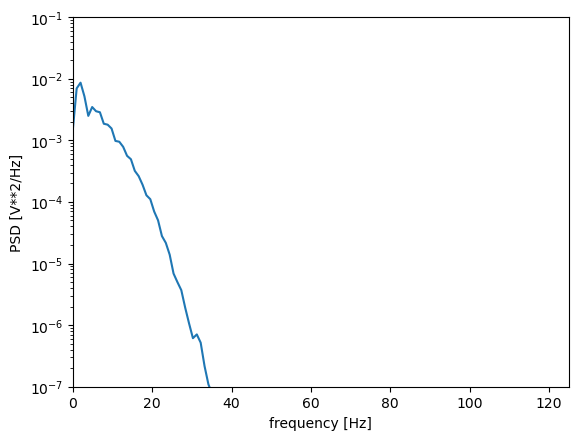

In [263]:
import scipy.signal

#Choose a random signal
random_patient = np.random.randint(0, X_train.shape[0])
signal = X_train[random_patient,:,1]
print("True Alarm: "+ str(y2_train[random_patient]))

# Define the sampling frequency
fs = 250

#Compute the power spectral density
(f, S) = scipy.signal.welch(signal, fs, scaling='density')
#(S, f) = scipy.signal.periodogram(signal, fs, scaling='density')

#plot PSD
plt.semilogy(f, S)
plt.ylim([1e-7, 1e-1])
plt.xlim([0,125])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [264]:
spectrum_length = len(S)
spectrum_length

129

In [265]:
# Create the datasset in the new domain
X_fourier = np.zeros((572, spectrum_length,3))

#We want to put every signal in the frequency domain
for patient in range(X_train.shape[0]):
    for signal_type in range(X_train.shape[2]):
        signal = X_train[patient,:,signal_type]
        (f, S) = scipy.signal.welch(signal, fs, scaling='density')
        X_fourier[patient,:,signal_type] =  S      
        

In [266]:
# Split in test and training
X_train, X_test, y_train, y_test = train_test_split(X_fourier, y2_train, test_size=0.05, random_state=42)

In [267]:
# Use LDA to reduce the dimensionality, we are creating a new dataset foe each signal
lda_signal_0 = LinearDiscriminantAnalysis()
lda_signal_1 = LinearDiscriminantAnalysis()
lda_signal_2 = LinearDiscriminantAnalysis()
X_train_new_0 = lda_signal_0.fit_transform(X_train[:,:,0], y_train)
X_train_new_1 = lda_signal_1.fit_transform(X_train[:,:,1], y_train)
X_train_new_2 = lda_signal_2.fit_transform(X_train[:,:,2], y_train)

In [268]:
# Join the three dataset, in this way we will have only 1 value for every signal --> 3 values for each patient
X_train_new = np.column_stack((X_train_new_0, X_train_new_1,X_train_new_2))

In [269]:
# Update the test set from time domain to frequency domain 
X_test_new_0 = lda_signal_0.transform(X_test[:,:,0])
X_test_new_1 = lda_signal_1.transform(X_test[:,:,1])
X_test_new_2 = lda_signal_2.transform(X_test[:,:,2])

In [270]:
# Join the 3 test sets
X_test_new = np.column_stack((X_test_new_0, X_test_new_1,X_test_new_2))

In [271]:
# Define an objective function to be minimized.
def objective(trial):

    lr = trial.suggest_float('lr', 1e-5, 1e-2)
    alpha = trial.suggest_float('alpha', 1e-5, 1e-2)
    
    mlp = MLPClassifier(random_state=1,
                        max_iter=3000,
                        validation_fraction=0.2,
                        learning_rate_init = lr,
                        alpha = alpha,
                        early_stopping=True).fit(X_train_new, y_train)
    
    accuracy = mlp.score(X_test_new, y_test)

    return accuracy  # An objective value linked with the Trial object.

study = optuna.create_study(direction = 'maximize')  # Create a new study.
study.optimize(objective, n_trials=100)  # Invoke optimization of the objective function.

[I 2022-11-28 12:21:11,376] A new study created in memory with name: no-name-ba9bd901-ad5b-406b-8a82-9e20471b713b
[I 2022-11-28 12:21:11,455] Trial 0 finished with value: 0.7931034482758621 and parameters: {'lr': 0.006729374329523517, 'alpha': 0.0025099674905101343}. Best is trial 0 with value: 0.7931034482758621.
[I 2022-11-28 12:21:11,689] Trial 1 finished with value: 0.7586206896551724 and parameters: {'lr': 0.00026070549377498966, 'alpha': 0.002267660480038554}. Best is trial 0 with value: 0.7931034482758621.
[I 2022-11-28 12:21:11,765] Trial 2 finished with value: 0.7931034482758621 and parameters: {'lr': 0.008818972522754015, 'alpha': 0.007108728188774206}. Best is trial 0 with value: 0.7931034482758621.
[I 2022-11-28 12:21:11,825] Trial 3 finished with value: 0.7931034482758621 and parameters: {'lr': 0.0022850003445265537, 'alpha': 0.008333439009376987}. Best is trial 0 with value: 0.7931034482758621.
[I 2022-11-28 12:21:11,888] Trial 4 finished with value: 0.7931034482758621 an

[I 2022-11-28 12:21:14,927] Trial 38 finished with value: 0.6896551724137931 and parameters: {'lr': 0.001299518425481673, 'alpha': 0.003752849216921405}. Best is trial 7 with value: 0.8275862068965517.
[I 2022-11-28 12:21:15,050] Trial 39 finished with value: 0.5172413793103449 and parameters: {'lr': 0.00016807783077699362, 'alpha': 0.004763963534510587}. Best is trial 7 with value: 0.8275862068965517.
[I 2022-11-28 12:21:15,125] Trial 40 finished with value: 0.6896551724137931 and parameters: {'lr': 0.002605562303302401, 'alpha': 0.002109057739219148}. Best is trial 7 with value: 0.8275862068965517.
[I 2022-11-28 12:21:15,235] Trial 41 finished with value: 0.7931034482758621 and parameters: {'lr': 0.006068850371250086, 'alpha': 0.0025352505124641832}. Best is trial 7 with value: 0.8275862068965517.
[I 2022-11-28 12:21:15,416] Trial 42 finished with value: 0.7931034482758621 and parameters: {'lr': 0.004402025632493757, 'alpha': 0.0005706413699395289}. Best is trial 7 with value: 0.8275

[I 2022-11-28 12:21:18,755] Trial 77 finished with value: 0.8275862068965517 and parameters: {'lr': 0.007061497398114571, 'alpha': 0.0035664161583704172}. Best is trial 7 with value: 0.8275862068965517.
[I 2022-11-28 12:21:18,849] Trial 78 finished with value: 0.8275862068965517 and parameters: {'lr': 0.00853756629949436, 'alpha': 0.004292957012003195}. Best is trial 7 with value: 0.8275862068965517.
[I 2022-11-28 12:21:18,916] Trial 79 finished with value: 0.7931034482758621 and parameters: {'lr': 0.007783420015052637, 'alpha': 0.004356120516536045}. Best is trial 7 with value: 0.8275862068965517.
[I 2022-11-28 12:21:18,988] Trial 80 finished with value: 0.7931034482758621 and parameters: {'lr': 0.00928404194490515, 'alpha': 0.003982810866644433}. Best is trial 7 with value: 0.8275862068965517.
[I 2022-11-28 12:21:19,065] Trial 81 finished with value: 0.8275862068965517 and parameters: {'lr': 0.007010132949009119, 'alpha': 0.0037085164105495256}. Best is trial 7 with value: 0.82758620

In [272]:
mlp = MLPClassifier(random_state=1,
                        max_iter=3000,
                        validation_fraction=0.2,
                        learning_rate_init = study.best_params['lr'],
                        alpha = study.best_params['alpha'],
                        early_stopping=True).fit(X_train_new, y_train)

In [273]:
# Test the classifier
test_accuracy = mlp.score(X_test_new, y_test)
print(f"The accuracy on the test set is: {np.round(test_accuracy, decimals = 2)*100}%")

The accuracy on the test set is: 83.0%


In [275]:
# Plot the results
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(0,len(mlp.loss_curve_)),
                         y=np.repeat(0.75, len(mlp.validation_scores_)),
                         mode='lines',
                         name='Old Test Accuracy'))
fig.add_trace(go.Scatter(x=np.arange(0,len(mlp.validation_scores_)), y=mlp.validation_scores_,
                    mode='lines',
                    name='Accuracy Validation'))
fig.add_trace(go.Scatter(x=np.arange(0,len(mlp.validation_scores_)),
                         y=np.repeat(test_accuracy, len(mlp.validation_scores_)),
                         mode='lines',
                         name='Test Accuracy'))
fig.add_trace(go.Scatter(x=np.arange(0,len(mlp.loss_curve_)), y=mlp.loss_curve_,
                    mode='lines',
                    name='Training Loss'))

fig.update_layout(
    xaxis_title="Epochs",
    yaxis_title="Loss\Accuracy",
    title={
        'text': "Performances",
        'y':0.9,
        'x':0.45,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

In [283]:
data = {"Old_Accuracy": np.repeat(0.75, len(mlp.validation_scores_)),
        "Test_Accuracy": np.repeat(test_accuracy, len(mlp.validation_scores_)),
        "Validation_Accuracy": mlp.validation_scores_ }

In [284]:
import pandas as pd
accuracies = pd.DataFrame(data)
accuracies.head()

,Old_Accuracy,Test_Accuracy,Validation_Accuracy
0,0.75,0.827586,0.743119
1,0.75,0.827586,0.825688
2,0.75,0.827586,0.807339
3,0.75,0.827586,0.807339
4,0.75,0.827586,0.807339


In [286]:
os.makedirs('Data', exist_ok=True)  
accuracies.to_csv('Data/accuracies.csv')  